In [98]:
from typing import List
from typing import Tuple
import os
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [99]:
def plot_residuals(y_train, y_train_pred, y_test, y_test_pred):

    train_residuals = y_train - y_train_pred
    test_residuals = _y_test - y_test_pred

    fig, axes = plt.subplots(3, 2, figsize=(14, 6))

    sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, ax=axes[0][0])
    axes[0][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0][0].set_xlabel("Real Values")
    axes[0][0].set_ylabel("Predict Values")
    axes[0][0].set_title("Train - Predict vs Real")
    axes[0][0].grid(True)

    sns.scatterplot(x=_y_test, y=y_test_pred, alpha=0.6, ax=axes[0][1])
    axes[0][1].plot([_y_test.min(), _y_test.max()], [_y_test.min(), _y_test.max()], 'r--', lw=2)
    axes[0][1].set_xlabel("Real Values")
    axes[0][1].set_ylabel("Predict Values")
    axes[0][1].set_title("Test - Predict vs Real")
    axes[0][1].grid(True)

    sns.scatterplot(x=y_train, y=train_residuals, alpha=0.6, ax=axes[1][0])
    axes[1][0].axhline(0, color='r', linestyle='--')
    axes[1][0].set_xlabel("Real Values")
    axes[1][0].set_ylabel("Residual error")
    axes[1][0].set_title("Train (Residual Error Plot)")
    axes[1][0].grid(True)

    sns.scatterplot(x=y_test, y=test_residuals, alpha=0.6, ax=axes[1][1])
    axes[1][1].axhline(0, color='r', linestyle='--')
    axes[1][1].set_xlabel("Real Values")
    axes[1][1].set_ylabel("Residual Error")
    axes[1][1].set_title("Test (Residual Error Plot)")
    axes[1][1].grid(True)

    sns.histplot(train_residuals, kde=True, ax=axes[2][0], color='blue', bins=30)
    axes[2][0].set_xlabel("Residual Error")
    axes[2][0].set_ylabel("Frequency")
    axes[2][0].set_title("Train - Histogram of residuals")
    axes[2][0].grid(True)

    sns.histplot(test_residuals, kde=True, ax=axes[2][1], color='blue', bins=30)
    axes[2][1].set_xlabel("Residual Error")
    axes[2][1].set_ylabel("Frequency")
    axes[2][1].set_title("Test - Histogram of residuals")
    axes[2][1].grid(True)

    plt.tight_layout()
    plt.show()

In [100]:
def print_result(y_train, y_train_pred, y_test, y_test_pred):
    print("Train MSE:", mean_squared_error(y_train, y_train_pred))
    print("Test MSE :", mean_squared_error(y_test, y_test_pred))
    print("\n")

    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("\n")

    print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Test MAE :", mean_absolute_error(y_test, y_test_pred))
    print("\n")

    print("Train R²:", r2_score(y_train, y_train_pred))
    print("Test R² :", r2_score(y_test, y_test_pred))
    print("\n")

    print("Train Explained Variance Score:", explained_variance_score(y_train, y_train_pred))
    print("Test Explained Variance Score:", explained_variance_score(y_test, y_test_pred))

In [101]:
def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the target and feature data by merging sales and demographics.

    Args:
        sales_path: path to CSV file with home sale data
        demographics_path: path to CSV file with home sale data
        sales_column_selection: list of columns from sales data to be used as
            features

    Returns:
        Tuple containg with two elements: a DataFrame and a Series of the same
        length.  The DataFrame contains features for machine learning, the
        series contains the target variable (home sale price).

    """
    data = pd.read_csv(sales_path, dtype={'zipcode': str})

    demographics = pd.read_csv(os.path.join(path, "zipcode_demographics.csv"), dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left", on="zipcode").drop(columns="zipcode")

    return merged_data

## Loading the dataset

In [102]:
path = "../data"

SALES_PATH = os.path.join(path, "kc_house_data.csv")  # path to CSV with home sale data
DEMOGRAPHICS_PATH = os.path.join(path, "kc_house_data.csv")  # path to CSV with demographics
# List of columns (subset) that will be taken from home sale data
SALES_COLUMN_SELECTION = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'zipcode'
]
OUTPUT_DIR = os.path.join(path, "model")  # Directory where output artifacts will be saved

In [103]:
df = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)

## Performing some data analysis

In [104]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_sbrbn,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0.0,0.0,0.0,4.0,8.0,20.0,21.0,5.0,12.0,4.0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,0.0,0.0,0.0,2.0,5.0,15.0,20.0,5.0,20.0,12.0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0.0,0.0,0.0,1.0,4.0,13.0,20.0,6.0,19.0,9.0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0.0,0.0,0.0,1.0,3.0,13.0,20.0,7.0,25.0,12.0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0.0,0.0,0.0,1.0,5.0,15.0,19.0,5.0,19.0,7.5


In [105]:
df.shape

(21613, 46)

In [106]:
print(f"{df.isnull().sum()} \n")

id                        0
date                      0
price                     0
bedrooms                  0
bathrooms                 0
sqft_living               0
sqft_lot                  0
floors                    0
waterfront                0
view                      0
condition                 0
grade                     0
sqft_above                0
sqft_basement             0
yr_built                  0
yr_renovated              0
lat                       0
long                      0
sqft_living15             0
sqft_lot15                0
ppltn_qty                 0
urbn_ppltn_qty            0
sbrbn_ppltn_qty           0
farm_ppltn_qty            0
non_farm_qty              0
medn_hshld_incm_amt       0
medn_incm_per_prsn_amt    0
hous_val_amt              0
edctn_less_than_9_qty     0
edctn_9_12_qty            0
edctn_high_schl_qty       0
edctn_some_clg_qty        0
edctn_assoc_dgre_qty      0
edctn_bchlr_dgre_qty      0
edctn_prfsnl_qty          0
per_urbn            

In [107]:
df.dtypes

id                          int64
date                       object
price                     float64
bedrooms                    int64
bathrooms                 float64
sqft_living                 int64
sqft_lot                    int64
floors                    float64
waterfront                  int64
view                        int64
condition                   int64
grade                       int64
sqft_above                  int64
sqft_basement               int64
yr_built                    int64
yr_renovated                int64
lat                       float64
long                      float64
sqft_living15               int64
sqft_lot15                  int64
ppltn_qty                 float64
urbn_ppltn_qty            float64
sbrbn_ppltn_qty           float64
farm_ppltn_qty            float64
non_farm_qty              float64
medn_hshld_incm_amt       float64
medn_incm_per_prsn_amt    float64
hous_val_amt              float64
edctn_less_than_9_qty     float64
edctn_9_12_qty

In [108]:
for col in df.columns:
    print(f"Unique values for {col}:")
    print(df[col].value_counts())
    print("\n")

Unique values for id:
id
795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: count, Length: 21436, dtype: int64


Unique values for date:
date
20140623T000000    142
20140626T000000    131
20140625T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20141102T000000      1
20150131T000000      1
20150524T000000      1
20140517T000000      1
20140727T000000      1
Name: count, Length: 372, dtype: int64


Unique values for price:
price
350000.0     172
450000.0     172
550000.0     159
500000.0     152
425000.0     150
            ... 
607010.0       1
1362500.0      1
298800.0       1
957500.0       1
402101.0       1
Name: count, Length: 4028, dtype: int64


Unique values for bedrooms:
bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33  

In [109]:
filtered_df = df[df['id'] == 795000620]
display(filtered_df)

print("The number of times '?' occurs in sqft_basement is:", (df.sqft_basement == "?").sum())

print((df.isna().sum() / len(df)) * 100)

filtered_df = df[df['bedrooms'] == 33]
display(filtered_df)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_sbrbn,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl
17602,795000620,20140924T000000,115000.0,3,1.0,1080,6250,1.0,0,0,...,0.0,0.0,0.0,5.0,11.0,23.0,18.0,5.0,6.0,2.0
17603,795000620,20141215T000000,124000.0,3,1.0,1080,6250,1.0,0,0,...,0.0,0.0,0.0,5.0,11.0,23.0,18.0,5.0,6.0,2.0
17604,795000620,20150311T000000,157000.0,3,1.0,1080,6250,1.0,0,0,...,0.0,0.0,0.0,5.0,11.0,23.0,18.0,5.0,6.0,2.0


The number of times '?' occurs in sqft_basement is: 0
id                        0.0
date                      0.0
price                     0.0
bedrooms                  0.0
bathrooms                 0.0
sqft_living               0.0
sqft_lot                  0.0
floors                    0.0
waterfront                0.0
view                      0.0
condition                 0.0
grade                     0.0
sqft_above                0.0
sqft_basement             0.0
yr_built                  0.0
yr_renovated              0.0
lat                       0.0
long                      0.0
sqft_living15             0.0
sqft_lot15                0.0
ppltn_qty                 0.0
urbn_ppltn_qty            0.0
sbrbn_ppltn_qty           0.0
farm_ppltn_qty            0.0
non_farm_qty              0.0
medn_hshld_incm_amt       0.0
medn_incm_per_prsn_amt    0.0
hous_val_amt              0.0
edctn_less_than_9_qty     0.0
edctn_9_12_qty            0.0
edctn_high_schl_qty       0.0
edctn_some_clg_q

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_sbrbn,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,0.0,0.0,0.0,0.0,3.0,9.0,16.0,5.0,33.0,17.0


# Encoding the datetime

In [110]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df['day_sin'] = np.sin(df['day']*(2 * np.pi / 31))
df['day_cos'] = np.cos(df['day']*(2 * np.pi / 31))

df['month_sin'] = np.sin(df['month']*(2 * np.pi / 12))
df['month_cos'] = np.cos(df['month']*(2 * np.pi / 12))

price                     1.000000
sqft_living               0.702035
grade                     0.667434
sqft_above                0.605567
sqft_living15             0.585379
hous_val_amt              0.579733
medn_incm_per_prsn_amt    0.549911
bathrooms                 0.525138
per_prfsnl                0.500262
per_hsd                   0.494371
Name: price, dtype: float64


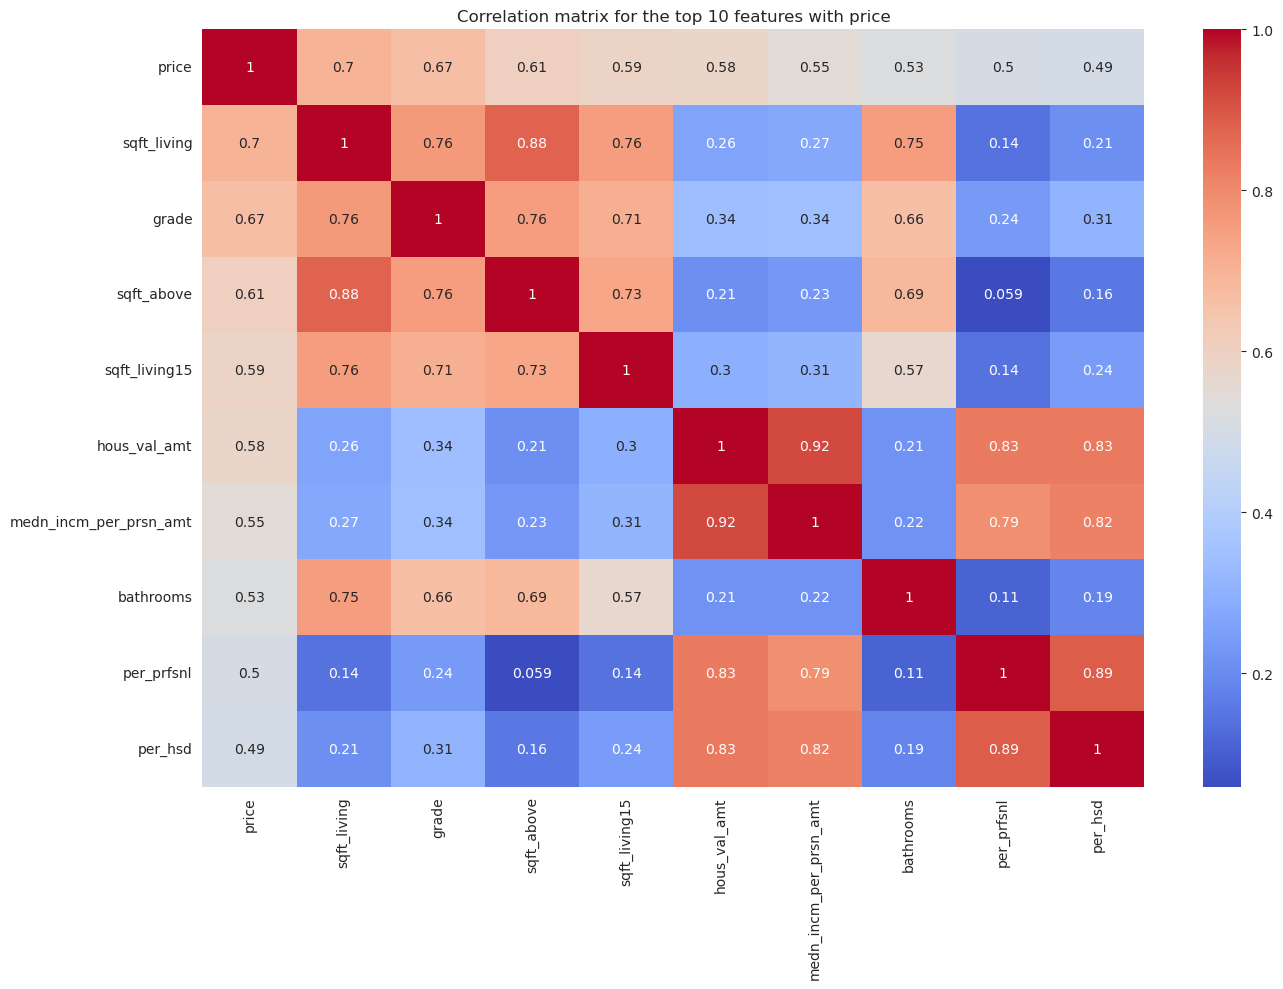

In [111]:
top_10_features = df.corr()['price'].abs().sort_values(ascending=False).head(10)

print(top_10_features)

top_corr_df = df[top_10_features.head(10).index]

corr_matrix = top_corr_df.corr().abs()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation matrix for the top 10 features with price")

plt.tight_layout()
plt.show()


# Multicolinearity among features

/tmp/ipykernel_102204/3638705449.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.


Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'hous_val_amt', 'medn_incm_per_prsn_amt', 'bathrooms', 'per_prfsnl',
       'per_hsd'],
      dtype='object')
   Correlations                      Features
1      0.876597     [sqft_living, sqft_above]
0      0.762704          [sqft_living, grade]
2      0.756420  [sqft_living, sqft_living15]
3      0.754665      [sqft_living, bathrooms]


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.
findfont: Font family 'Silom' not found.


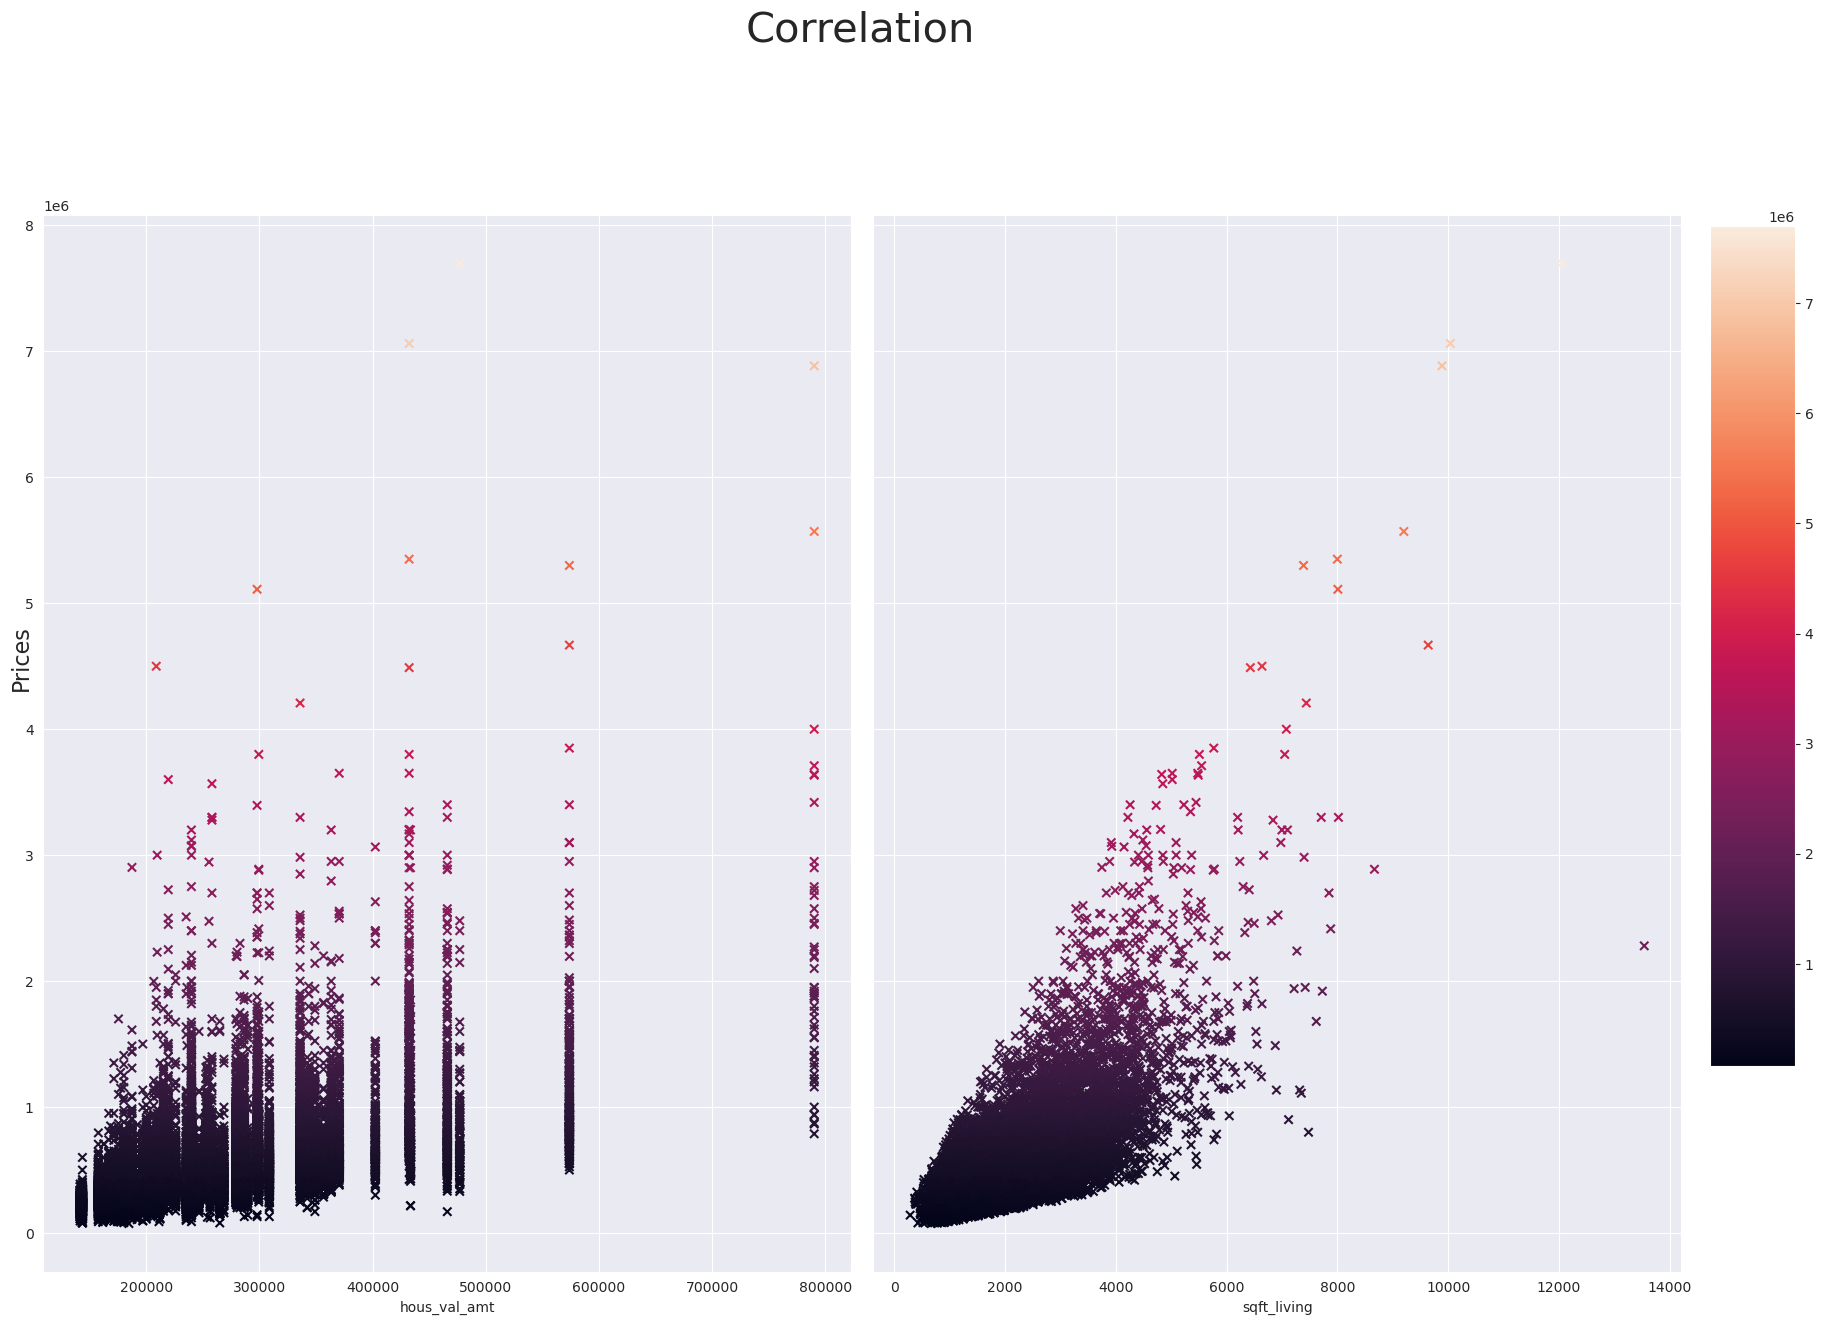

In [112]:
Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr_matrix[feature].items():
        if correlation >= .7 and idx != feature and idx != 'price':
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)

print(corr_matrix.columns)

for feature in ['sqft_living']:
      check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features}).sort_values(by=['Correlations'], ascending=False)

print(MC_df)

price = df['price']
sqft_living = df['sqft_living']
hous_val_amt = df['hous_val_amt']

f = plt.figure()
f, axes = plt.subplots(nrows = 1, ncols = 2, sharex=False, sharey = True, figsize=(17,12))

f.suptitle('Correlation', fontsize=30, y=1.1, fontname='Silom')
f.text(0.0001, 0.56, 'Prices', va='center', rotation='vertical', fontsize=16, fontname='Silom')

sc = axes[0].scatter(hous_val_amt, price, c = price, marker = "x")
axes[0].set_xlabel('hous_val_amt')

axes[1].scatter(sqft_living, price, c = price, marker = "x")
axes[1].set_xlabel('sqft_living')

cbar_ax = f.add_axes([1, 0.22, 0.05, 0.7])

f.colorbar(sc, cax=cbar_ax)

f.tight_layout()
plt.show()

### Training a linear regression with the most correlated features

In [113]:
used_features = ['sqft_living', 'hous_val_amt']

x = df[used_features]
y = df['price']
x_train, _x_test, y_train, _y_test = model_selection.train_test_split(x, y, random_state=42)

In [114]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
_x_test_scaled = scaler.transform(_x_test)

linreg = LinearRegression()
linreg.fit(x_train_scaled, y_train)

y_train_pred = linreg.predict(x_train_scaled)
_y_pred = linreg.predict(_x_test_scaled)

print_result(y_train, y_train_pred, _y_test, _y_pred)


Train MSE: 43741649110.29699
Test MSE : 51978750635.01616


Train RMSE: 209145.0432362598
Test RMSE : 227988.4879440542


Train MAE: 130451.25263387433
Test MAE : 136302.19485184943


Train R²: 0.6630349964161404
Test R² : 0.6525197129662228


Train Explained Variance Score: 0.6630349964161404
Test Explained Variance Score: 0.6526515321577591


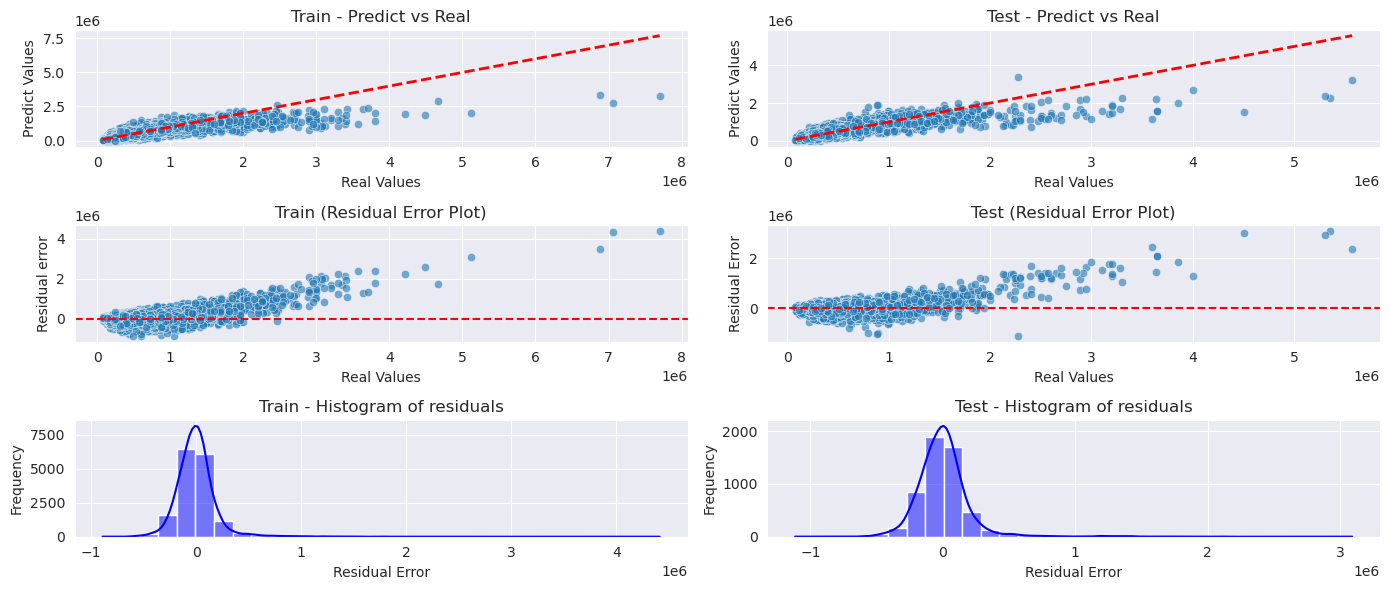

In [115]:
plot_residuals(y_train, y_train_pred, _y_test, _y_pred)

### Training a RandomForest with all features

In [116]:
x = df.drop(columns=['date', 'day', 'month', 'id', 'price'])
y = df['price']
x_train, _x_test, y_train, _y_test = model_selection.train_test_split(x, y, random_state=42)

print(x_train.shape)
print(_x_test.shape)

(16209, 48)
(5404, 48)


In [117]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [118]:
y_train_pred = model.predict(x_train)
_y_pred = model.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

Train MSE: 2077072245.5560243
Test MSE : 18167412204.57634


Train RMSE: 45574.90806963876
Test RMSE : 134786.54311382995


Train MAE: 24961.716925781973
Test MAE : 70156.08843819392


Train R²: 0.9839992165155255
Test R² : 0.878550031880635


Train Explained Variance Score: 0.9839992701055094
Test Explained Variance Score: 0.8785662686957985


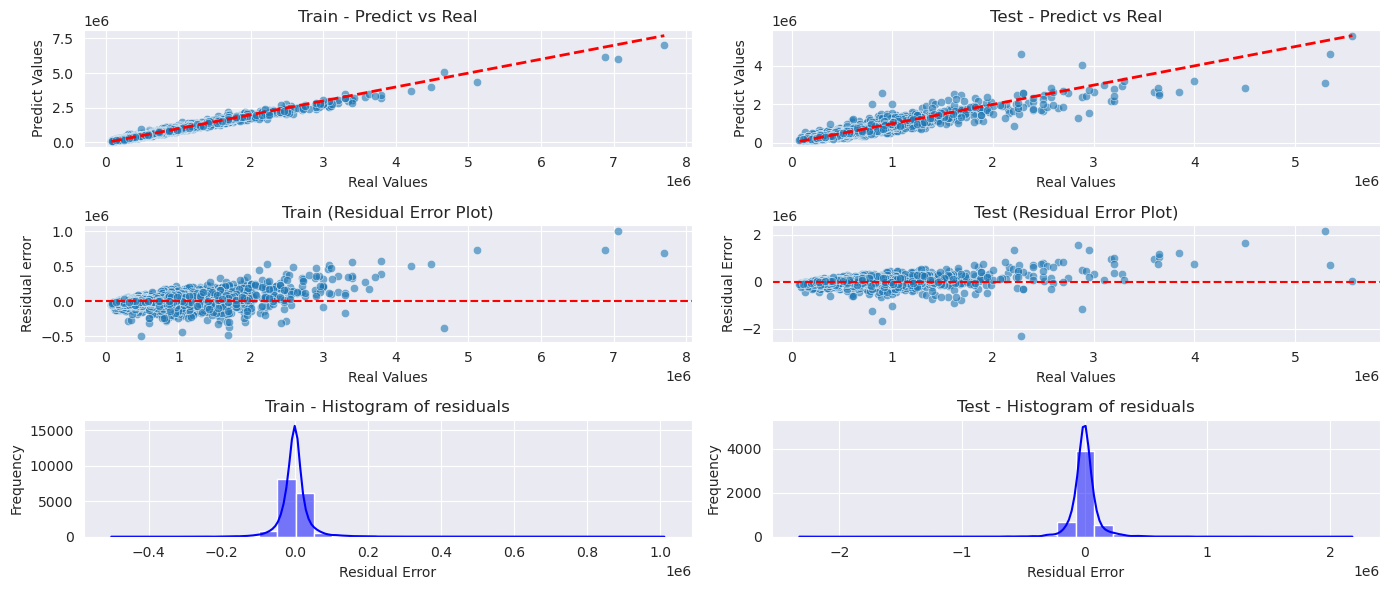

In [119]:
train_residuals = y_train - y_train_pred
test_residuals = _y_test - _y_pred

plot_residuals(y_train, y_train_pred, _y_test, _y_pred)

### Feature Importance Analysis

         Feature  Importance
8          grade    0.324818
2    sqft_living    0.248977
41     per_bchlr    0.084505
24  hous_val_amt    0.064485
13           lat    0.043315
5     waterfront    0.030615
42    per_prfsnl    0.026294
6           view    0.021235
14          long    0.019620
9     sqft_above    0.018100


/tmp/ipykernel_102204/2551608872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(10), x='Importance', y='Feature', palette='viridis')


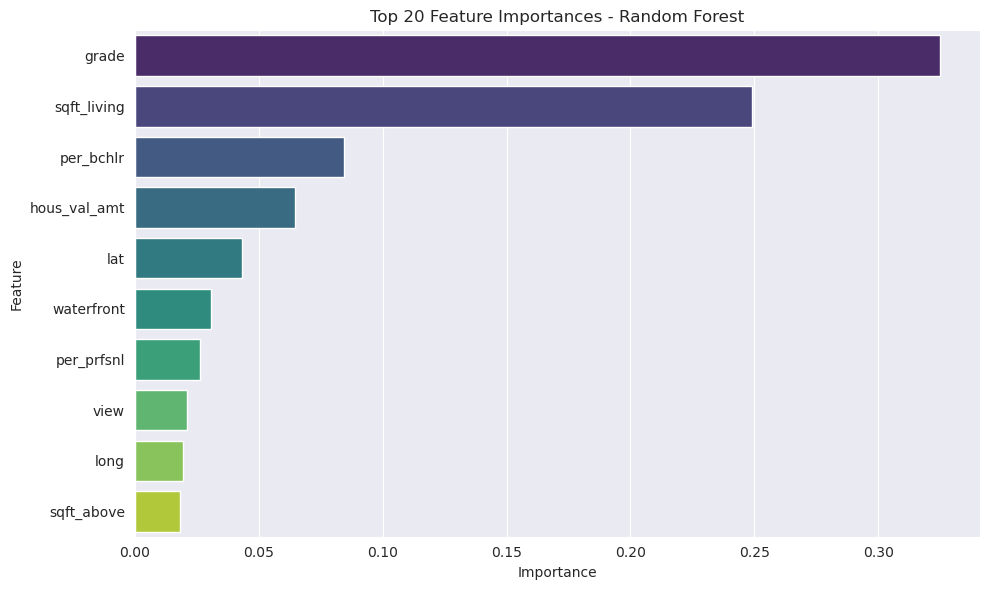

In [120]:
importances = model.feature_importances_
feature_names = x_train.columns

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

### Finding better hyperparameters for RandomForest with GridSearch

In [121]:
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 2, 5, 10, 20, 30]
}

clf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=3,
    refit=True
)

clf.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5, 10, 20, 30],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [122]:
y_train_pred = clf.predict(x_train)
_y_pred = clf.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

Train MSE: 2247943376.4436936
Test MSE : 18567708673.831554


Train RMSE: 47412.48123061789
Test RMSE : 136263.37979747733


Train MAE: 26900.50094024454
Test MAE : 70655.65396274347


Train R²: 0.9826829060333404
Test R² : 0.875874031970362


Train Explained Variance Score: 0.9826829063338831
Test Explained Variance Score: 0.8758887440192491


### Training a Gradient Boosting Regressor with GridSearch

In [123]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

clf_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=3,
    refit=True
)

clf_gb.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=3)

In [124]:
y_train_pred = clf_gb.predict(x_train)
_y_pred = clf_gb.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

Train MSE: 6477531507.689351
Test MSE : 17885766525.308056


Train RMSE: 80483.1131833837
Test RMSE : 133737.6780316903


Train MAE: 54596.8020583994
Test MAE : 69732.47272246337


Train R²: 0.9501001568962499
Test R² : 0.8804328459205715


Train Explained Variance Score: 0.9501001573813519
Test Explained Variance Score: 0.8804380529955337


### Training a SVR with GridSearch

In [129]:
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

categorical_columns = ['waterfront', 'view', 'condition', 'grade']
numerical_columns = [col for col in df.columns if col not in categorical_columns and col not in ['price', 'day', 'month', 'date', 'id']]

print(categorical_columns)
print(numerical_columns)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('num', StandardScaler(), numerical_columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('svr', SVR())
])

param_grid = {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.5],
    'svr__gamma': [0.01, 0.1],
}

clf_svr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=3,
    refit=True
)

clf_svr.fit(x_train, y_train)

['waterfront', 'view', 'condition', 'grade']
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'ppltn_qty', 'urbn_ppltn_qty', 'sbrbn_ppltn_qty', 'farm_ppltn_qty', 'non_farm_qty', 'medn_hshld_incm_amt', 'medn_incm_per_prsn_amt', 'hous_val_amt', 'edctn_less_than_9_qty', 'edctn_9_12_qty', 'edctn_high_schl_qty', 'edctn_some_clg_qty', 'edctn_assoc_dgre_qty', 'edctn_bchlr_dgre_qty', 'edctn_prfsnl_qty', 'per_urbn', 'per_sbrbn', 'per_farm', 'per_non_farm', 'per_less_than_9', 'per_9_to_12', 'per_hsd', 'per_some_clg', 'per_assoc', 'per_bchlr', 'per_prfsnl', 'year', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['waterfront',
                                                                          'view',
                                                                          'condition',
                                                                          'grade']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors',
                                                                          'sqft_above',
                                                                          'sqft_basement',
                                                                          'yr_built',
                                                                          'yr_renovated',
                                                                          'lat',
                                                                          'long',
                                                                          'sqft_living15',
                                                                          'sqft_lot15...
                                                                          'edctn_less_than_9_qty',
                                                                          'edctn_9_12_qty',
                                                                          'edctn_high_schl_qty',
                                                                          'edctn_some_clg_qty',
                                                                          'edctn_assoc_dgre_qty',
                                                                          'edctn_bchlr_dgre_qty',
                                                                          'edctn_prfsnl_qty',
                                                                          'per_urbn',
                                                                          'per_sbrbn', ...])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100], 'svr__epsilon': [0.1, 0.5],
                         'svr__gamma': [0.01, 0.1], 'svr__kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [130]:
y_train_pred = clf_svr.predict(x_train)
_y_pred = clf_svr.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

Train MSE: 111929676250.74821
Test MSE : 132672093250.75237


Train RMSE: 334558.92791965394
Test RMSE : 364241.80601731094


Train MAE: 179083.03398141474
Test MAE : 189401.5449688971


Train R²: 0.13774664361945588
Test R² : 0.1130810863875017


Train Explained Variance Score: 0.19320465964682942
Test Explained Variance Score: 0.17412252537859785


### Removing duplicate properties

In [131]:
df_with_date = df.copy()

display(df_with_date[df_with_date['id'] == 795000620])
display(df_with_date[df_with_date['id'] == 6308000010])

df_with_date = df_with_date.loc[df_with_date.groupby('id')['date'].idxmax()]
display(df_with_date[df_with_date['id'] == 795000620])
display(df_with_date[df_with_date['id'] == 6308000010])

df_with_date.drop(columns=['day', 'month', 'date', 'id'], inplace=True)

x = df_with_date.drop(columns=['price'])
y = df_with_date['price']
x_train, _x_test, y_train, _y_test = model_selection.train_test_split(x, y, random_state=42)

print(x_train.shape)
print(_x_test.shape)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
_y_pred = model.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_assoc,per_bchlr,per_prfsnl,year,month,day,day_sin,day_cos,month_sin,month_cos
17602,795000620,2014-09-24,115000.0,3,1.0,1080,6250,1.0,0,0,...,5.0,6.0,2.0,2014,9,24,-0.988468,0.151428,-1.000000e+00,-1.836970e-16
17603,795000620,2014-12-15,124000.0,3,1.0,1080,6250,1.0,0,0,...,5.0,6.0,2.0,2014,12,15,0.101168,-0.994869,-2.449294e-16,1.000000e+00
17604,795000620,2015-03-11,157000.0,3,1.0,1080,6250,1.0,0,0,...,5.0,6.0,2.0,2015,3,11,0.790776,-0.612106,1.000000e+00,6.123234e-17


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_assoc,per_bchlr,per_prfsnl,year,month,day,day_sin,day_cos,month_sin,month_cos
14982,6308000010,2014-12-08,585000.0,3,2.5,2290,5089,2.0,0,0,...,4.0,27.0,15.0,2014,12,8,0.998717,-0.050649,-2.449294e-16,1.0
14983,6308000010,2015-04-23,585000.0,3,2.5,2290,5089,2.0,0,0,...,4.0,27.0,15.0,2015,4,23,-0.998717,-0.050649,8.660254e-01,-0.5


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_assoc,per_bchlr,per_prfsnl,year,month,day,day_sin,day_cos,month_sin,month_cos
17604,795000620,2015-03-11,157000.0,3,1.0,1080,6250,1.0,0,0,...,5.0,6.0,2.0,2015,3,11,0.790776,-0.612106,1.0,6.123234e-17


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,per_assoc,per_bchlr,per_prfsnl,year,month,day,day_sin,day_cos,month_sin,month_cos
14983,6308000010,2015-04-23,585000.0,3,2.5,2290,5089,2.0,0,0,...,4.0,27.0,15.0,2015,4,23,-0.998717,-0.050649,0.866025,-0.5


(16077, 48)
(5359, 48)
Train MSE: 2109417884.7725687
Test MSE : 15487538768.961992


Train RMSE: 45928.3995450807
Test RMSE : 124448.94040915732


Train MAE: 24978.25142252908
Test MAE : 67881.84301922


Train R²: 0.9842344601077652
Test R² : 0.8879396370861045


Train Explained Variance Score: 0.9842347649969022
Test Explained Variance Score: 0.8879851733992169


## Filtering out some features

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'sqft_living'}>],
       [<Axes: title={'center': 'sqft_lot'}>,
        <Axes: title={'center': 'floors'}>],
       [<Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_basement'}>],
       [<Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'per_bchlr'}>],
       [<Axes: title={'center': 'hous_val_amt'}>, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
      

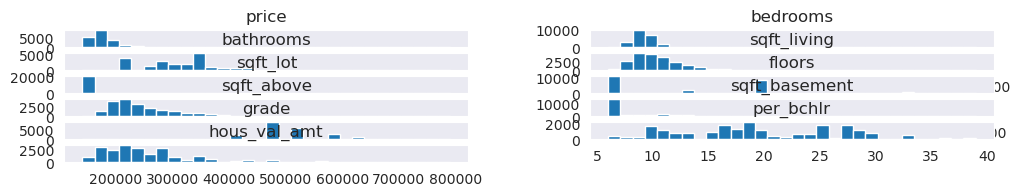

In [148]:
df_filtered = df.loc[df.groupby('id')['date'].idxmax()]

df_filtered_plot = df_filtered[[
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'grade', 'per_bchlr', 'hous_val_amt'
]]

df_filtered_plot.select_dtypes(include='number').hist(bins=30, figsize=(12, 8), layout=(len(df_filtered.columns)//2+1, 2), grid=False)

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>],
       [<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'sqft_living'}>],
       [<Axes: title={'center': 'sqft_lot'}>,
        <Axes: title={'center': 'floors'}>],
       [<Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_basement'}>],
       [<Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'per_bchlr'}>],
       [<Axes: title={'center': 'hous_val_amt'}>, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
      

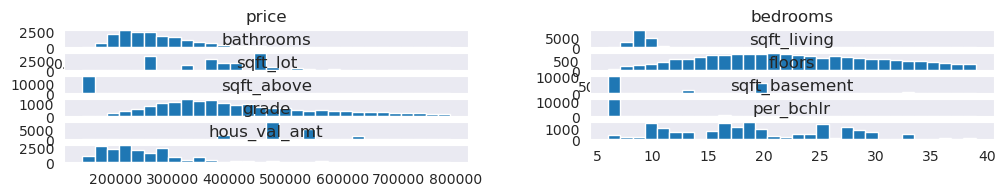

In [149]:
df_filtered = df_filtered[(df_filtered['sqft_living'] > 600) & (df_filtered['sqft_living'] < 3000)]

df_filtered_plot = df_filtered[[
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'grade', 'per_bchlr', 'hous_val_amt'
]]

df_filtered_plot.select_dtypes(include='number').hist(bins=30, figsize=(12, 8), layout=(len(df_filtered.columns)//2+1, 2), grid=False)

In [151]:
x = df_filtered.drop(columns=['price', 'day', 'month', 'date', 'id'])
y = df_filtered['price']

x_train, _x_test, y_train, _y_test = model_selection.train_test_split(x, y, random_state=42)

print(x_train.shape)
print(_x_test.shape)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

(13701, 48)
(4568, 48)


RandomForestRegressor(random_state=42)

In [152]:
y_train_pred = model.predict(x_train)
_y_pred = model.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

Train MSE: 1003832604.0001973
Test MSE : 7136208753.670907


Train RMSE: 31683.317439943017
Test RMSE : 84476.0839153361


Train MAE: 20135.983834756586
Test MAE : 54243.63523423818


Train R²: 0.9778499192747181
Test R² : 0.8400284085552442


Train Explained Variance Score: 0.9778499466200044
Test Explained Variance Score: 0.8400590955990611


## Training a SVR

In [139]:
categorical_columns = ['waterfront', 'view', 'condition', 'grade', 'bedrooms', 'bathrooms']
numerical_columns = [col for col in df.columns if col not in categorical_columns and col not in ['price', 'day', 'month', 'date', 'id']]

print(categorical_columns)
print(numerical_columns)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('num', StandardScaler(), numerical_columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('svr', SVR(kernel='poly', degree=5, C=100, gamma=0.01))
])

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
_y_pred = pipeline.predict(_x_test)

print_result(y_train, y_train_pred, _y_test, _y_pred)

['waterfront', 'view', 'condition', 'grade', 'bedrooms', 'bathrooms']
['sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'ppltn_qty', 'urbn_ppltn_qty', 'sbrbn_ppltn_qty', 'farm_ppltn_qty', 'non_farm_qty', 'medn_hshld_incm_amt', 'medn_incm_per_prsn_amt', 'hous_val_amt', 'edctn_less_than_9_qty', 'edctn_9_12_qty', 'edctn_high_schl_qty', 'edctn_some_clg_qty', 'edctn_assoc_dgre_qty', 'edctn_bchlr_dgre_qty', 'edctn_prfsnl_qty', 'per_urbn', 'per_sbrbn', 'per_farm', 'per_non_farm', 'per_less_than_9', 'per_9_to_12', 'per_hsd', 'per_some_clg', 'per_assoc', 'per_bchlr', 'per_prfsnl', 'year', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
Train MSE: 133861365624.84366
Test MSE : 156031271903.60086


Train RMSE: 365870.6952255724
Test RMSE : 395007.9390386994


Train MAE: 215721.24045727972
Test MAE : 226247.7084189179


Train R²: -0.031204731988430767
Test R² : -0.04307607406754488


Train Explained Varian